<a href="https://colab.research.google.com/github/Nicordaro/Project_MLDL/blob/master/Project_MLDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Politecnico di Torino**

**01TXFSM - Machine learning and Deep learning**

**Incremental Learning in Image Classification**

**Cordaro Nicolò - s272145**

**Di Nepi Marco - s277959**

**Falletta Alberto - s277971**


In [0]:
# !pip3 install 'torch==1.4.0'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'


# ---------------------------------------------------------------------------- #
# An implementation of https://arxiv.org/pdf/1512.03385.pdf                    #
# See section 4.2 for the model architecture on CIFAR-10                       #
# Some part of the code was referenced from below                              #
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py   #
# ---------------------------------------------------------------------------- #

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 80
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [2, 2, 2]).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'resnet.ckpt')

**Imports**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn


import torchvision
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.models import resnet34
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
from google.colab import drive

**Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

# Init at 10 because first train is on 10 classes
NUM_CLASSES = 10

# Used for the pseudorandom shuffle of the split
SEED = 42

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 2               # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 1e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 70      # Total number of training epochs (iterations over dataset)
MILESTONES = [48, 62]  # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.2          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 50

**Pre-processing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))                                 
])

**Prepare Dataset**

CIFAR100 has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another.

Each of the downloaded files is a Python "pickled" object produced with cPickle.

In [0]:
# Clone github repository with data
# if os.path.isdir('./Project_MLDL'):
!rm -rf Project_MLDL
if not os.path.isdir('./CIFAR100_tError'):
  !git clone https://github.com/Nicordaro/Project_MLDL


Cloning into 'Project_MLDL'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 116 (delta 52), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (116/116), 267.64 KiB | 4.70 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [0]:
from Project_MLDL.CIFAR100_tError import CIFAR100_tError
import numpy as np
import random

DATA_DIR = './CIFAR100'

lbls = [i for i in range(0,100)]  #Array of classes integer-encoded (?)
random.seed(SEED)
random.shuffle(lbls)

def make_data_labels(lbls):       #After shuffle, take first 10 classes, and remove the first 10 from the list passed as argument
  new_labels=[]
  for el in lbls[:10]:
    new_labels.append(el)
  lbls = lbls[10:]

  return lbls, new_labels

**Network Definition**

In [0]:
net = resnet34(pretrained=False)

**Train & Test**

In [8]:
import numpy as np
BATCH_TO_TEST = 10
accuracies = []

# Define test dataset outside in order to increment it, instead of initializing it every cycle iteration
test_dataset = CIFAR100_tError(DATA_DIR, train=False, transform=eval_transform, download=True)
for i in range(0,BATCH_TO_TEST): #one iteration for 10 classes
  print(f'Starting training with batch {i+1}')
  lbls, new_labels = make_data_labels(lbls)
  
  # Define Train dataset
  train_dataset = CIFAR100_tError(DATA_DIR, train=True, transform=train_transform, download=True)       
  
  # Increment dataset with new labels mapped with list comprehension
  train_dataset.increment(new_labels,[j for j in range(0+i*10,10+i*10)])
  test_dataset.increment(new_labels,[j for j in range(0+i*10,10+i*10)])

  # Change number of neurons in last fully connected layer
  net.fc = nn.Linear(512, NUM_CLASSES*(i+1))

  # Define dataloader
  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
  test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

  #prepare training
  # Loss function
  criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

  # Parameters to optimize:
  parameters_to_optimize = net.parameters()

  # Optimizer
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  # Scheduler
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA, last_epoch=-1)

  # training 
  # By default, everything is loaded to cpu
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0

  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):
    # if epoch==5:
    #   for g in optimizer.param_groups:
    #     g['lr'] = g['lr']/5
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
    
    # Iterate over the dataset
    for images, labels in train_dataloader:
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      # Forward pass to the network
      outputs = net(images)

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)
      
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

      current_step += 1

    # Step the scheduler
    scheduler.step()

  #test phase
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    #Debugging purpose, print labels of predictions
    ##print(preds)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(test_dataset))

  #Store accuracies for plotting purposes
  accuracies.append(accuracy)

  print('Test Accuracy: {}'.format(accuracy))

Extracting ./CIFAR100/cifar-100-python.tar.gz to ./CIFAR100

Starting training with batch 1
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 2.4161643981933594
Starting epoch 2/70, LR = [2]
Step 50, Loss 2.192978858947754
Starting epoch 3/70, LR = [2]
Step 100, Loss 2.2067017555236816
Starting epoch 4/70, LR = [2]
Step 150, Loss 2.1758909225463867
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 2.290205717086792
Starting epoch 7/70, LR = [2]
Step 250, Loss 2.212653875350952
Starting epoch 8/70, LR = [2]
Step 300, Loss 2.349425792694092
Starting epoch 9/70, LR = [2]
Step 350, Loss 2.251753330230713
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 2.199799060821533
Starting epoch 12/70, LR = [2]
Step 450, Loss 2.1317996978759766
Starting epoch 13/70, LR = [2]
Step 500, Loss 2.1756036281585693
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 2.2345762252807617
Starting epoch 

100%|██████████| 8/8 [00:02<00:00,  3.61it/s]


Test Accuracy: 0.471
Starting training with batch 2
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 2.9910809993743896
Starting epoch 2/70, LR = [2]
Step 50, Loss 1.7576228380203247
Starting epoch 3/70, LR = [2]
Step 100, Loss 1.7363481521606445
Starting epoch 4/70, LR = [2]
Step 150, Loss 1.734616756439209
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 1.5708307027816772
Starting epoch 7/70, LR = [2]
Step 250, Loss 1.3637359142303467
Starting epoch 8/70, LR = [2]
Step 300, Loss 1.6876633167266846
Starting epoch 9/70, LR = [2]
Step 350, Loss 1.396590232849121
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.9706441760063171
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.9702295064926147
Starting epoch 13/70, LR = [2]
Step 500, Loss 1.1185846328735352
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 1.0455896854400635
Starting epoch 16/70, LR = [2]
Step 600, Loss 0.708

100%|██████████| 16/16 [00:04<00:00,  3.65it/s]


Test Accuracy: 0.295
Starting training with batch 3
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 3.407163143157959
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.9748956561088562
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.8198649883270264
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.7856689691543579
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.38841551542282104
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.34966516494750977
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.23888790607452393
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.17567753791809082
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.19250716269016266
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.14582568407058716
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.07887175679206848
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.023564234375953674
Starting epoch 16/70, LR = [2]
Step 600, 

100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Test Accuracy: 0.23433333333333334
Starting training with batch 4
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 3.7015345096588135
Starting epoch 2/70, LR = [2]
Step 50, Loss 1.0738680362701416
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.9872848987579346
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.6154298782348633
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.21584996581077576
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.2359674870967865
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.13476106524467468
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.22308072447776794
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.06797028332948685
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.04022693634033203
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.018725961446762085
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.019750073552131653
Starting epoch 16/70, LR =

100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


Test Accuracy: 0.16025
Starting training with batch 5
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 3.8876471519470215
Starting epoch 2/70, LR = [2]
Step 50, Loss 1.2892258167266846
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.8095085620880127
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.41479238867759705
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.2696545720100403
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.3381359279155731
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.16197152435779572
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.1729421615600586
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.04935172200202942
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.025505468249320984
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.05735251307487488
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.03174012899398804
Starting epoch 16/70, LR = [2]
Step 600,

100%|██████████| 40/40 [00:11<00:00,  3.39it/s]


Test Accuracy: 0.1454
Starting training with batch 6
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 4.0951762199401855
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.9956743717193604
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.48032501339912415
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.34840089082717896
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.13431650400161743
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.15255707502365112
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.13670168817043304
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.09134314954280853
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.05563312768936157
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.011603720486164093
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.09276062250137329
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.060411855578422546
Starting epoch 16/70, LR = [2]
Step 

100%|██████████| 47/47 [00:12<00:00,  3.81it/s]


Test Accuracy: 0.12316666666666666
Starting training with batch 7
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 4.237577438354492
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.9929183125495911
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.6570228934288025
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.621487021446228
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.16144995391368866
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.18063993752002716
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.1605527698993683
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.08256378024816513
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.05003763735294342
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.025819331407546997
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.022536158561706543
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.03837987780570984
Starting epoch 16/70, LR = [

100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Test Accuracy: 0.11028571428571429
Starting training with batch 8
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 4.368732452392578
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.7390010952949524
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.46889594197273254
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.39673012495040894
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.20143911242485046
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.19667978584766388
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.04709078371524811
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.3551825284957886
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.05759480595588684
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.018852025270462036
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.019774213433265686
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.06472748517990112
Starting epoch 16/70, LR 

100%|██████████| 63/63 [00:16<00:00,  3.85it/s]


Test Accuracy: 0.093625
Starting training with batch 9
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 4.469107627868652
Starting epoch 2/70, LR = [2]
Step 50, Loss 1.234461784362793
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.7936851978302002
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.4971882402896881
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.09676381945610046
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.23694857954978943
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.07587867230176926
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.1358298361301422
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.04777845740318298
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.06140561401844025
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.11995645612478256
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.015862025320529938
Starting epoch 16/70, LR = [2]
Step 600,

100%|██████████| 71/71 [00:18<00:00,  3.83it/s]


Test Accuracy: 0.07955555555555556
Starting training with batch 10
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 4.594821453094482
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.7398671507835388
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.4005187153816223
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.350361704826355
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.13937467336654663
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.11403337866067886
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.22429536283016205
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.04669661819934845
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.02099752426147461
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.02660621702671051
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.02641911804676056
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.02460409700870514
Starting epoch 16/70, LR = [

100%|██████████| 79/79 [00:20<00:00,  3.84it/s]

Test Accuracy: 0.0746


In [9]:
print(accuracies)
# accuracies_old = [0.655, 0.358, 0.259, 0.172, 0.1596, 0.125, 0.11057142857142857, 0.09725, 0.08044444444444444, 0.0749] #5e-5


# iCaRL parameters
# accuracies_def = [0.443, 0.2885, 0.22833333333333333, 0.159, 0.1432, 0.11883333333333333, 0.10871428571428571, 0.092125, 0.07711111111111112, 0.0694] 
# accuracies_def_2 = [0.471, 0.295, 0.23433333333333334, 0.16025, 0.1454, 0.12316666666666666, 0.11028571428571429, 0.093625, 0.07955555555555556, 0.0746]

[0.471, 0.295, 0.23433333333333334, 0.16025, 0.1454, 0.12316666666666666, 0.11028571428571429, 0.093625, 0.07955555555555556, 0.0746]


**Define plot function**

In [0]:
def accuracy_plot(accuracies):
  from scipy import interpolate

  tck,u     = interpolate.splprep( [[i*10 for i in range(1,len(accuracies)+1)],accuracies] ,s = 0 )
  xnew,ynew = interpolate.splev( np.linspace( 0, 1, 100 ), tck,der = 0)

  fig, ax = plt.subplots(figsize=(15,14), facecolor='white')

  plt.rc('font', size=20)
  plt.plot( [i*10 for i in range(1,len(accuracies)+1)],accuracies,'.' , xnew ,ynew, label = "accuracy", c='orange' )
  ax.set_ylabel("Accuracy")
  ax.set_xlabel("Classes")
  ax.minorticks_on()
  plt.title("Accuracies obtained with finetuning of a ResNet network")
  # # Customize the major grid
  # ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
  # # Customize the minor grid
  # ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  plt.yticks(np.arange(0, 1.1, .1))
  plt.xticks(np.arange(0, 110, 10))
  plt.grid(axis='y',which='major', linestyle='-', linewidth='0.5', color='black') 
  plt.grid(axis='y',which='minor', linestyle=':', linewidth='0.5', color='grey')
  for in_i, in_j in zip([i*10 for i in range(1,len(accuracies)+1)], accuracies):  # Plot also the value of the point close to it
          ax.annotate(str(round(in_j, 3)), xy=(in_i, in_j))

  plt.savefig('test.png', format='png', dpi=300)
  plt.show()

**Plot accuracies**

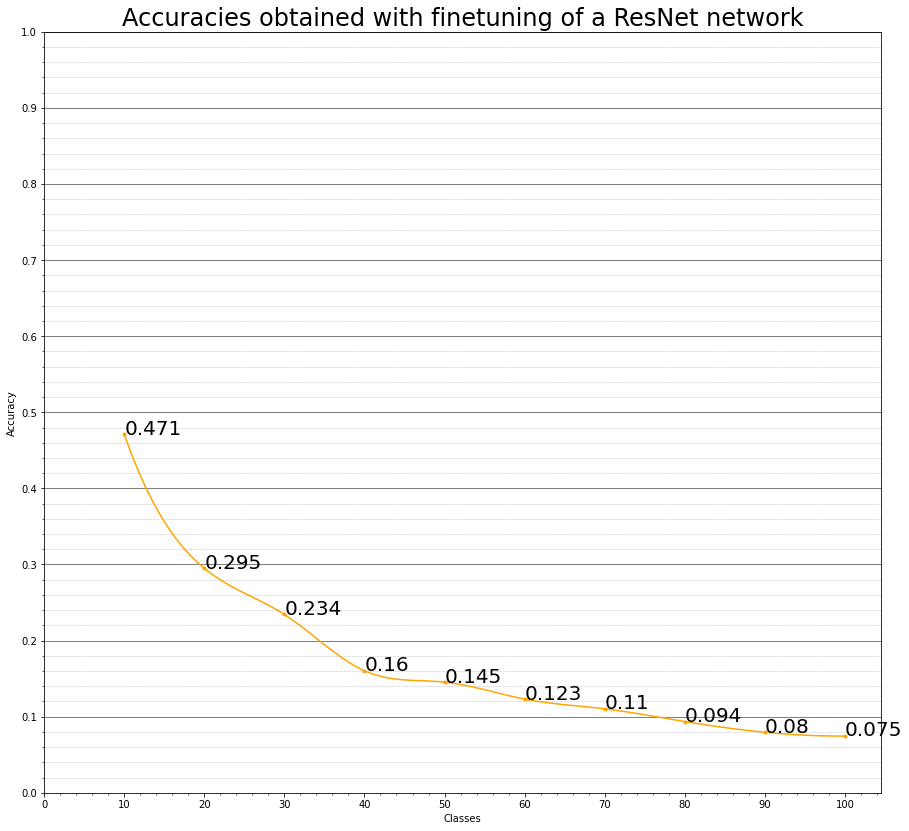

In [11]:
accuracy_plot(accuracies)